# Learning to Rank

This notebook is about learning to rank. After working on a few related projects, i have compiled an anonymized dataset to show what you can do with such data.

## Dataset overview

We'll start this with an overview of the dataset

In [1]:
import pandas as pd

df = pd.read_csv('data/ltr.csv')

In [2]:
df.shape

(1709, 38)

In [3]:
df.head()

,query_id,doc_id,rel_human,rel_clicks,D.0,D.1,D.2,D.3,Q.0,Q.1,...,QD.15,QD.16,QD.17,QD.18,QD.19,QD.20,QD.21,action,query,last_jobtitle
0,00da8ed9-18aa-48e8-98fe-07a49241ef82,11825afc-1e6c-3e5b-8572-4ec43647fda9,2.0,0,0.1,0.1,0.4,0.533333,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.059649,SaveResume,school psychologist,Psychologist
1,00da8ed9-18aa-48e8-98fe-07a49241ef82,2adc9883-3e32-3e1f-96ef-2a9bcd0cbe57,1.0,0,0.2,0.1,0.4,0.000000,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.059649,SaveResume,school psychologist,Psychologist
2,00da8ed9-18aa-48e8-98fe-07a49241ef82,e02cca7b-837c-3dcc-bdbb-5cff9975a20b,1.0,0,0.2,0.1,0.4,0.433333,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.127225,-,school psychologist,Research Psychologist
3,00da8ed9-18aa-48e8-98fe-07a49241ef82,db17e3c3-f4e8-3ce0-ac39-b700130358cf,1.0,0,0.2,0.1,0.4,0.666667,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.117020,-,school psychologist,Licensed Clinical Psychologist
4,00da8ed9-18aa-48e8-98fe-07a49241ef82,3f1a6869-5de4-3673-bc5f-9b859efe25b7,2.0,0,0.2,0.1,0.4,0.500000,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.117020,-,school psychologist,Continuing Care Clinical Psychologist


Above we have taken a first look at the dataset, we have 1709 rows of data, and 38 columns of identifiers, annotations, click actions, features and document information.

The dataset is about matching job seekers with jobs.

Some explanation of the columns:
* **query_id/doc_id** : query and document identifiers
* **rel_human/rel_clicks** : relevance as determined by human annotation and as extracted from logging data
* **action** : The action(s) observed in the logs for this query and search result
* **D...** : Document related features
* **Q...** : Query related features
* **QD...** : Query-document or matching related features
* **query/last_jobtitle** : The query and jobtitle of this person.

The columns starting with DOC... QUERY... or QUERY_DOC... are features available for modelling later on. The query and jobtitle are there to allow understandeable display of results.

## Looking for relations

First thing to do it, inspect the dataset for relations. Our end goal is using Learning to Rank (LTR) to improve the order of search results, to get the best results to the top of the list.

But first we need to see if and what relations exist in the data and if there is any variables that we could use to improve the ordering.

First off, how often do we observe the various actions and how do they relate to the human assessed relevance?

In [16]:
df.groupby('action').size()

action
-                 1396
DownloadResume     124
ForwardResume       29
GetResume          157
SaveResume           3
dtype: int64

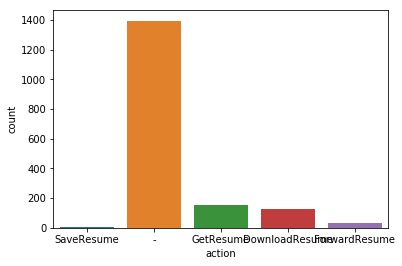

In [17]:
import seaborn as sns

%matplotlib inline

df['action'].fillna('-', inplace=True)

_ = sns.countplot(df['action'])

So most common, users do nothing with the results ;-) Second is inspection and viewing ('Get', 'Download') and then comes the rest.

Let's see how these actions relate to human assessed relevance?

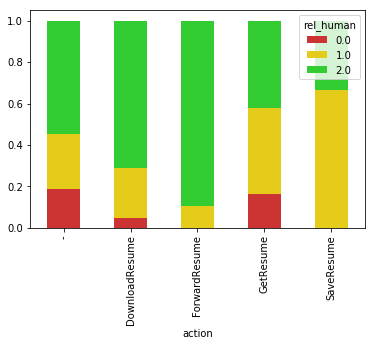

In [18]:
colours = [(0.8, 0.2, 0.2), (0.9, 0.8, 0.1), (0.2, 0.8, 0.2)]

_ = pd.crosstab(df['action'], df['rel_human']).apply(lambda r: r/r.sum(), axis=1).plot.bar(stacked=True, color=colours)

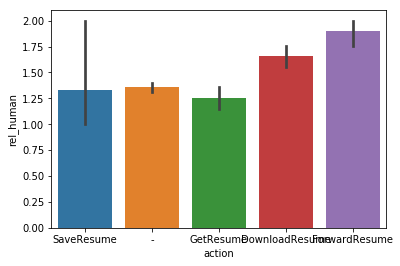

In [19]:
_ = sns.barplot(x=df['action'], y=df['rel_human'])

What the plots show, there seems to be a relation between the actions and the relevance. Different actions show a different mean relevance and the distribution of relevances is quite different between the actions.

It appears the 'Download' and 'Forward' actions show a positive relation with high relevance. While the 'Get' action is less clear. Finally the 'Save' action occurs to infrequent to say much.

From the product this data was gathered from, these relations make sense: Users can click on search results to expand them and see more detail (The 'Get' action) and then they can choose to 'Download' or 'Forward' resumes if they appear interesting.

This tells us those signals could be usefull inputs for a LTR machine learning model.

## Statistical tests

Out of curiosity and for practise i will also do a statistical test to confirm or disprove there is a relation between the action and the human assessed relevance.

* **Null Hypothesis**: There is no relationship between action and human assessment
* **Alternative Hypothesis**: There is a relationship between action and human assessment.

Because both variables are categorical, we need to use a Chi-squared test.

So let's see!

In [8]:
contingency_table = pd.crosstab(df['action'], df['rel_human'])

contingency_table

rel_human,0.0,1.0,2.0
action,,,
-,264,370,762
DownloadResume,6,30,88
ForwardResume,0,3,26
GetResume,26,65,66
SaveResume,0,2,1


In [9]:
from scipy.stats import chi2_contingency

chi2, p, dof, _ = chi2_contingency(contingency_table)

print("Chi^2 = {:.1f}, P-value = {:.2f}, DoF = {}".format(chi2, p, dof))

Chi^2 = 52.7, P-value = 0.00, DoF = 8


The result of this test confirms there is a relationship, we accept the alternative hypothesis. 

## Feature correlation?

The next thing that interested me, if there is correlation between the annotated relevance and any of the features?

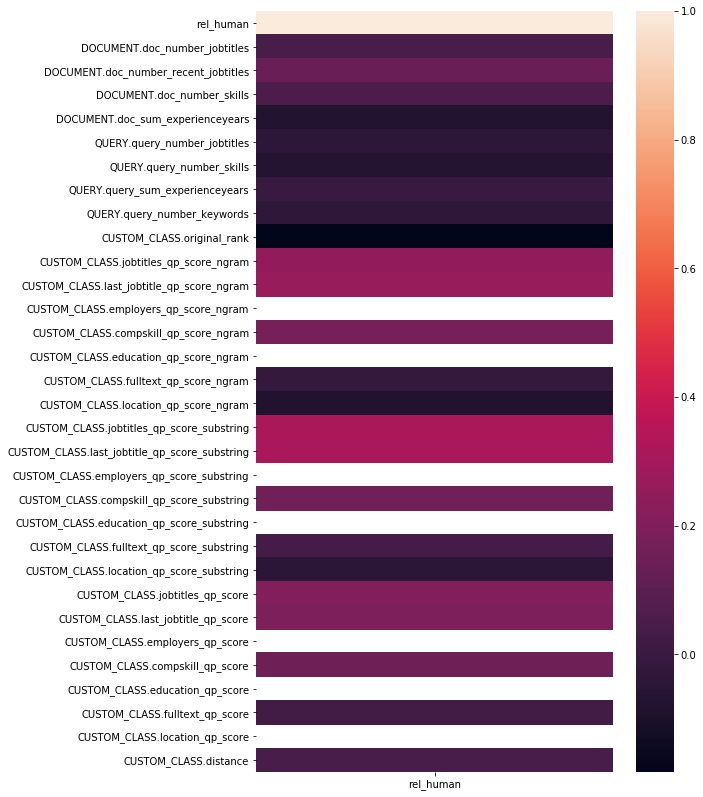

In [25]:
from matplotlib import pyplot as plt

feats_cols = ['rel_human'] + [x for x in df.columns if x.split('.')[0] in ('DOCUMENT', 'QUERY', 'CUSTOM_CLASS')]

plt.figure(figsize = (8,14))
_ = sns.heatmap(df[feats_cols].corr()[['rel_human']])

#df[feats_cols].corr()[['rel_human']]

It appears there is some nice correlations. Let's see what our LTR model can make of it?!

## Tossing it into a model!

For reranking we will use LightGBM library. That has a nice python interface and provides reranking functionality.

First we prepare the data. For ranking this is slightly different than usual:

* **X** -> the features
* **y** -> the relevance labels, note we are not going to predict this label, but instead only try to optimize the order!
* **groups** -> the samples are grouped per query, since relevance only matters within a query


In [5]:
df = df[df['rel_human'].isna() == False]

X = df[[x for x in df.columns if x.split('.')[0] in ('D', 'Q', 'QD')]]
y = df['rel_human']
groups = df['query_id']

Now we create a train and test set.

In [6]:
import numpy as np

unique_groups = groups.unique()

train_groups = set(np.random.choice(unique_groups, size=int(len(unique_groups)*0.75)))

train_indices = groups.map(lambda z: z in train_groups)
test_indices = groups.map(lambda z: z not in train_groups)

X_train = X[train_indices]
X_test = X[test_indices]

y_train = y[train_indices]
y_test = y[test_indices]

groups_train = groups[train_indices]
groups_test = groups[test_indices]
                     
groups_train = pd.Series(groups_train).groupby(groups_train).size()
groups_test = pd.Series(groups_test).groupby(groups_test).size()

An finally we can put the data into our model.

In [7]:
from lightgbm import LGBMRanker

model = LGBMRanker(n_estimators=25, num_leaves=7, colsample_bytree=0.75)

model.fit(X_train, y_train, group=groups_train,
          eval_set=[(X_test, y_test), (X_train, y_train)], eval_group=[groups_test, groups_train],
          eval_at=[10], verbose=5)

[5]	training's ndcg@10: 0.951931	valid_0's ndcg@10: 0.932954
[10]	training's ndcg@10: 0.962511	valid_0's ndcg@10: 0.936641
[15]	training's ndcg@10: 0.966654	valid_0's ndcg@10: 0.938942
[20]	training's ndcg@10: 0.969931	valid_0's ndcg@10: 0.938707
[25]	training's ndcg@10: 0.970102	valid_0's ndcg@10: 0.934231


LGBMRanker(boosting_type='gbdt', class_weight=None, colsample_bytree=0.75,
      learning_rate=0.1, max_depth=-1, min_child_samples=20,
      min_child_weight=0.001, min_split_gain=0.0, n_estimators=25,
      n_jobs=-1, num_leaves=7, objective=None, random_state=None,
      reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
      subsample_for_bin=200000, subsample_freq=1)

As a first inspection, we'll plot the score increase as the model trains. This should show a nice upward slope which flattens off.

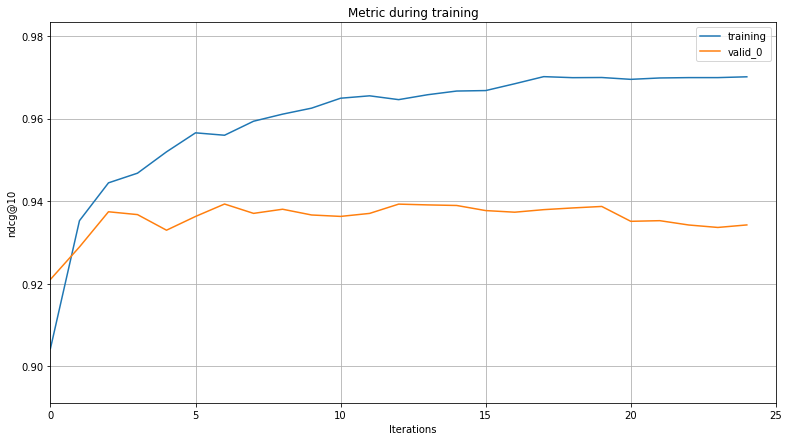

In [8]:
from lightgbm import plot_metric

%matplotlib inline

plot_metric(model, metric='ndcg@10', figsize=(13,7))

It should also be interesting to see which features the model has relied on for the predictions?

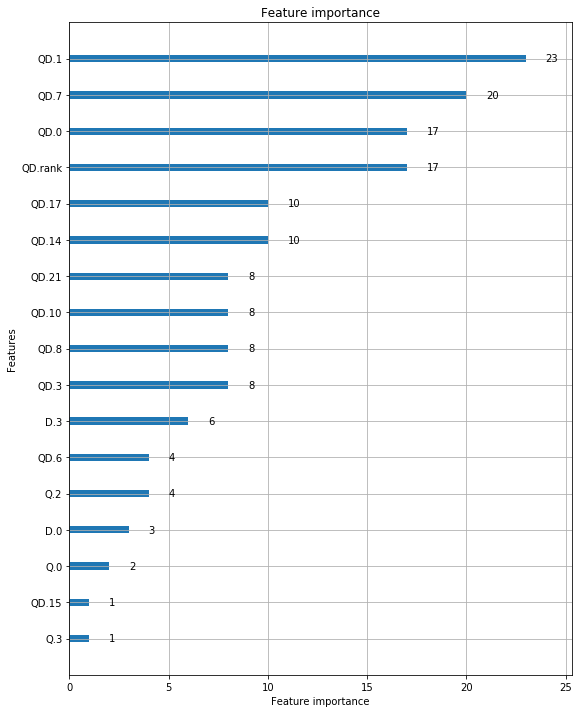

In [9]:
from lightgbm import plot_importance

plot_importance(model, max_num_features=25, figsize=(9,12))

## Finally: Inspecting prediction?

Now that we have a model that seems to improve quality of the ranking, let's see what it does to a list of search results? How does the model affect the result order? Do we like what we see?

In [54]:
df_pred = df[df['query_id'] == 'b1dea2de-dad9-4e7f-9b30-0759bd6ae1bd']

X_pred = df_pred[[x for x in df.columns if x.split('.')[0] in ('D', 'Q', 'QD')]]

df_pred['model_scores'] = model.predict(X_pred)

/home/dehling/Documents/machine-learnings/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [55]:
df_pred[['rel_human', 'model_scores', 'QD.rank', 'query', 'last_jobtitle']] \
    .sort_values(by='model_scores', ascending=False)

,rel_human,model_scores,QD.rank,query,last_jobtitle
1705,2.0,0.274862,3.0,"(""PMC Technician"" OR ""Preventative Maintenance...",Technician
1703,1.0,0.172677,1.0,"(""PMC Technician"" OR ""Preventative Maintenance...",Technician
1708,2.0,0.105317,6.0,"(""PMC Technician"" OR ""Preventative Maintenance...",Technician
1704,1.0,-0.243204,2.0,"(""PMC Technician"" OR ""Preventative Maintenance...",Assembler
1706,1.0,-0.362718,4.0,"(""PMC Technician"" OR ""Preventative Maintenance...","Design Engineer, 3D CAD Designer"
1707,1.0,-0.362718,5.0,"(""PMC Technician"" OR ""Preventative Maintenance...",NaN


The table above show us the re-ordered results for a query for a 'PMC Technician'. A few of the lower ranking results (see original_rank column) have moved up, and those have been relevant results (see rel_human column). So in this example, the reranker has done a good job!

Let's look at another result.

In [10]:
df_pred = df[df['query_id'] == 'a49fec79-3b4d-48dd-9679-1aa1ef09f082']

X_pred = df_pred[[x for x in df.columns if x.split('.')[0] in ('D', 'Q', 'QD')]]

df_pred['model_scores'] = model.predict(X_pred)

/home/dehling/Documents/machine-learnings/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [11]:
df_pred[['rel_human', 'model_scores', 'QD.rank', 'query', 'last_jobtitle']] \
    .sort_values(by='model_scores', ascending=False)

,rel_human,model_scores,QD.rank,query,last_jobtitle
1634,2.0,0.527631,2.0,"""marketing"" AND ""business intelligence"" AND ""t...",Business Analyst
1633,2.0,0.414389,1.0,"""marketing"" AND ""business intelligence"" AND ""t...",Assistant Business & Advertising Manager
1635,1.0,0.187150,3.0,"""marketing"" AND ""business intelligence"" AND ""t...",ANALYST INTERN
1636,0.0,-0.159523,4.0,"""marketing"" AND ""business intelligence"" AND ""t...",Sr. Data Scientist
1637,1.0,-0.331828,5.0,"""marketing"" AND ""business intelligence"" AND ""t...",NaN
